In [66]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import re
import matplotlib.pyplot as plt
from string import punctuation
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing import sequence

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#print long strings without truncating in pandas

pd.options.display.max_colwidth = 500
max_len_bert = 512


In [67]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/multiclass-train/my_train_set.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite
/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/testing/my_test_set.csv
/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv
/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv


In [68]:
movie_dataset = pd.read_csv("../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
clothing_dataset = pd.read_csv("../input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv", index_col = 0)
food_dataset = pd.read_csv("/kaggle/input/amazon-fine-food-reviews/Reviews.csv", index_col =[0])

In [69]:
clothing_dataset.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - ...",3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6,General,Tops,Blouses


In [70]:

movie_dataset.shape

(50000, 2)

In [71]:
clothing_dataset.shape

(23486, 10)

In [72]:
clothing_dataset['Review Text'].describe()

count                                                                                  22641
unique                                                                                 22634
top       Perfect fit and i've gotten so many compliments. i buy all my suits from here now!
freq                                                                                       3
Name: Review Text, dtype: object

In [73]:
movie_dataset.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,"Loved today's show!!! It was a variety and not solely cooking (which would have been great too). Very stimulating and captivating, always keeping the viewer peeking around the corner to see what was coming up next. She is as down to earth and as personable as you get, like one of us which made the show all the more enjoyable. Special guests, who are friends as well made for a nice surprise too. Loved the 'first' theme and that the audience was invited to play along too. I must admit I was sh...",positive
freq,5,25000


In [74]:
food_dataset.describe()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,1.743817,2.22881,4.183199,1.296257e+09
std,7.636513,8.28974,1.310436,4.804331e+07
min,0.000000,0.00000,1.000000,9.393408e+08
25%,0.000000,0.00000,4.000000,1.271290e+09
50%,0.000000,1.00000,5.000000,1.311120e+09
75%,2.000000,2.00000,5.000000,1.332720e+09
max,866.000000,923.00000,5.000000,1.351210e+09


Lets take a look at each of these datasets one at a time 

MOVIE DATASET:

In [75]:
print("The shape of the movie dataset is: {}".format (movie_dataset.shape))
print('\nSome sample datapoint:\n')

movie_dataset.sample(5)

The shape of the movie dataset is: (50000, 2)

Some sample datapoint:



,review,sentiment
4442,"I can't believe they even released such a movie. The only good acting came from the water in the movie. This has to be one of worst (if not the worst) movie I have ever seen.<br /><br />The only scary part of the movie is the bad acting, me giving this movie a 1 is me being to kind, this movie deserve a 0.<br /><br />The storyline, and if you can call it the plot of the movie, seems to have been written by an high school kid. Ofcaurse you have to ask yourself if it may have been better with ...",negative
5255,"This is another of Robert Altman's underrated films(let's be honest, the only movie he's made that really didn't work was Ready to Wear), and Sandy Dennis gives a spellbinding performance in it.She is far better here than she was in ""The Out of Towners"". The material, I will admit, is beneath the great director Altman and the extraordinary actress Dennis, but that hardly matters anyway.As long as there allowed to do their thing and do it well, just about any story will do.",positive
39176,"This film is another example of the curse of east Asian cinema: two or more separate stories rolled into one film. Other reviewers have obviously picked up on it as well because there are several mentions of the ""first part"" and ""second part"". How can you have any character development or a deep plot when the characters and the story are featured for such a short time? I was enjoying the first part until it abruptly stopped (it didn't ""end"", it just stopped in what appeared to be the middle ...",negative
16187,"Of all the movies I've seen, this one rates almost at the bottom (Haunted Mansion, Nothing but Trouble and a few others keep it from reaching rock bottom.) It is hasty, the story is shaky and the events depicted are poorly acted. Of course we have to lay some of this at the book writer's door. The book the movie was filmed after is outrageously ponderous, and illogical. Oprah gives a palatable appearance as ""Bigger's"" mom, but is not nearly at her potential. Other famous performers also seem...",negative
11412,"Is this movie as bad as some claim? In my opinion, yes it is. I wasn't going to comment, noting that quite a few comments have already been made, ranging from 'awful' to -not nearly so bad...'. However, I can't resist.<br /><br />What do you make of a movie that has, on the DVD cover. the phrase ""the real story of ""Ma BArker and her boys..."", and the standard ""any similarity to actual persons..."" disclaimer in the credits? I'm not naive, but in this case, it's a pretty relevant observation r...",negative


In [76]:
#Lets get how balanced our movie dataset is
movie_dataset.sentiment.value_counts(normalize = True)

positive    0.5
negative    0.5
Name: sentiment, dtype: float64

Our movie dataset is equally balanced. 

In [77]:
#Do we have any nans?
#which columns have nans
movie_dataset.isnull().sum()

review       0
sentiment    0
dtype: int64

In [78]:
#Lets convert the sentiments from categorical to numerical features
le = LabelEncoder()
movie_dataset['sentiment'] = le.fit_transform(movie_dataset['sentiment'])
movie_dataset.rename(columns = {'review':'Text', 'sentiment':'ratings'}, inplace=True)

movie_dataset.head()

,Text,ratings
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is calle...",1
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly wr...",1
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />T...",1
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ru...",0
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler's play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is conne...",1


Women E-ommerce clothing dataset

In [79]:
print("The shape of the women dataset is: {}".format (clothing_dataset.shape))
print('\nSome sample datapoint:\n')

clothing_dataset.sample(5)

The shape of the women dataset is: (23486, 10)

Some sample datapoint:



,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
19911,1102,44,Cool and comfy tunic,"Really like this tunic a lot. it is comfortable and easy to throw on and look put together. i'm always a fan of pockets too! i ordered the xs -- i'm 5'4"" about 118#. it fits loose but not in a bad way. the fabric allows it to fall well over the body. if you are tall it will probably be too short for you as it was a few inches above my knees. glad to have snagged this right away! more tunics like this please!",5,1,0,General,Dresses,Dresses
6092,828,42,Great off the shoulder top,Off the shoulder is everywhere and this is a great shirt for the fall.,5,1,1,General,Tops,Blouses
6686,1100,43,Great dress for all occasions!,"I really liked the dress on line, but, i didn't appreciate how lovely it was until i received it. it fit perfectly, and has a lovely flare at the hemline for a flirty feel. i wear it with taupe colored booties and it is perfect for work and afterwork.",5,1,0,General,Dresses,Dresses
2810,843,43,Great print!,Love this crinkle cotton top for spring. the print is great and i can't wait to wear it!,5,1,4,General,Tops,Blouses
6097,1081,42,"Cute style, terrible material","Fell in love with this dress when i saw it online and ordered it right away. however i was sadly disappointed once it arrived. while the cut is cute, the fabric is just all wrong. i was expecting a nice, heavy knit-like material, but this feels and looks really cheap - especially given the price of the dress. sadly it is going back.",2,0,20,General Petite,Dresses,Dresses


In [80]:
#WE are interested in only 2 columns in this dataset. So we will drop some of the columns

clothing_dataset.columns

Index(['Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')

In [81]:
clothing_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23486 entries, 0 to 23485
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              23486 non-null  int64 
 1   Age                      23486 non-null  int64 
 2   Title                    19676 non-null  object
 3   Review Text              22641 non-null  object
 4   Rating                   23486 non-null  int64 
 5   Recommended IND          23486 non-null  int64 
 6   Positive Feedback Count  23486 non-null  int64 
 7   Division Name            23472 non-null  object
 8   Department Name          23472 non-null  object
 9   Class Name               23472 non-null  object
dtypes: int64(5), object(5)
memory usage: 2.0+ MB


In [82]:
clothing_dataset.drop([col for col in clothing_dataset.columns if col not in ['Review Text', 'Rating']], axis=1, inplace=True)


In [83]:
clothing_dataset.head(3)

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comfortable,4
1,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5
2,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - ...",3


In [84]:
clothing_dataset.Rating.unique()

array([4, 5, 3, 2, 1])

In [85]:
#Do we have any null/empty cell
#which columns have nans
clothing_dataset.isnull().sum()


Review Text    845
Rating           0
dtype: int64

In [86]:
clothing_dataset.shape

(23486, 2)

In [87]:
#Dropping all the empty/ null cell from the clothing dataset
clothing_dataset = clothing_dataset[~clothing_dataset['Review Text'].isnull()]

clothing_dataset.shape

(22641, 2)

In [88]:
#we shall consider all ratings 1, 2 as negative reviews and reviews 4, 5 as positive reviews
#All reviews with Rating = 3 shall be considered neutrl reviews and for simplicity, shall be dropped.

clothing_reviews=clothing_dataset[clothing_dataset.Rating!=3]
clothing_reviews["ratings"]= clothing_dataset["Rating"].apply(lambda x: 1 if x > 3  else 0)
clothing_reviews.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Review Text,Rating,ratings
0,Absolutely wonderful - silky and sexy and comfortable,4,1
1,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1
3,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1
4,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1
5,"I love tracy reese dresses, but this one is not for the very petite. i am just under 5 feet tall and usually wear a 0p in this brand. this dress was very pretty out of the package but its a lot of dress. the skirt is long and very full so it overwhelmed my small frame. not a stranger to alterations, shortening and narrowing the skirt would take away from the embellishment of the garment. i love the color and the idea of the style but it just did not work on me. i returned this dress.",2,0


In [89]:
clothing_reviews=clothing_reviews.drop("Rating",axis=1)
clothing_reviews.rename(columns = {'Review Text':'Text'}, inplace=True)

clothing_reviews.head()

,Text,ratings
0,Absolutely wonderful - silky and sexy and comfortable,1
1,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",1
3,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",1
4,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,1
5,"I love tracy reese dresses, but this one is not for the very petite. i am just under 5 feet tall and usually wear a 0p in this brand. this dress was very pretty out of the package but its a lot of dress. the skirt is long and very full so it overwhelmed my small frame. not a stranger to alterations, shortening and narrowing the skirt would take away from the embellishment of the garment. i love the color and the idea of the style but it just did not work on me. i returned this dress.",0


In [90]:
clothing_reviews.ratings.value_counts()
# this dataset is very imbalanced

1    17448
0     2370
Name: ratings, dtype: int64

In [91]:
# clothing_reviews['food_len'] = clothing_reviews['Text'].apply(len)
# print(clothing_reviews['food_len'].describe())

# print('\n\nThe Longest sentence has Maximum length: ', max(clothing_reviews['food_len']))

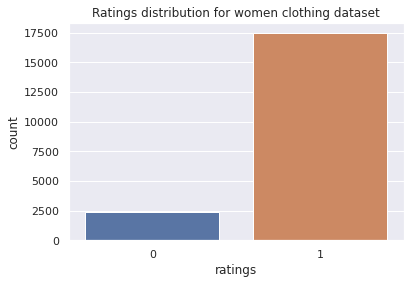

In [92]:
sns.set(style = 'darkgrid')
ax = sns.countplot(x = 'ratings', data = clothing_reviews)
ax.set_title('Ratings distribution for women clothing dataset');

Amazon fine food dataset

In [93]:
food_dataset.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters ..."
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The flavor is very medicinal.
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [94]:
food_dataset.drop([col for col in food_dataset.columns if col not in ['Text','Score']], axis=1, inplace=True)
food_dataset.head()

,Score,Text
Id,,
1,5,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.
2,1,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
3,4,"This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters ..."
4,2,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The flavor is very medicinal.
5,5,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [95]:
food_dataset.Score.unique()

array([5, 1, 4, 2, 3])

In [96]:
food_dataset.Score.value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

*Since i want to have a binary classification problem with only positive and negative reviews, I will focus mostly on the reviews with 1, 2 as my negative reviews and the reviews with 4, 5 as my positive reviews.For simplicity,  I will dropp all reviews with 3 as i consider them as neutral reviews. *

In [97]:
#we shall consider all ratings 1, 2 as negative reviews and reviews 4, 5 as positive reviews

food_reviews=food_dataset[food_dataset.Score!=3]
food_reviews["ratings"]= food_dataset['Score'].apply(lambda x: 1 if x > 3  else 0)
food_reviews=food_reviews.drop("Score",axis=1)

food_reviews.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Text,ratings
Id,,
1,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.,1
2,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",0
3,"This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters ...",1
4,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The flavor is very medicinal.,0
5,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",1


In [98]:
food_reviews.ratings.value_counts()


1    443777
0     82037
Name: ratings, dtype: int64

In [99]:
# food_reviews['food_len'] = food_reviews['Text'].apply(len)
# print(food_reviews['food_len'].describe())

# print('\n\nThe Longest sentence has Maximum length: ', max(food_reviews['food_len']))

this dataset is highly imbalanced. But we will not worrry about it now. We will have to extract an equal number of positive and negative reviews when we are creating our unified dataset.

In [100]:
#Lets find some empty cell and delete them
food_reviews.isnull().sum()

Text       0
ratings    0
dtype: int64

MULTICLASS DATASET CREATION

Description:

The main aim here was to create a unified dataset(multiclass_customer_review_data), which contains the movie_dataset, the women_dataset and the yelp_dataset into one dataset.

We attributed the

--- label '0' to the negative examples of all the 3 dataset.

--- label '1' for the positive examples from the movie_dataset

--- label '2' for the positive examples form the women_dataset

--- label '3' for the positive examples form the food_dataset

Since we are aiming for a balanced dataset, we are going to creat a balanced dataset for all the 3 datasets we are using, before creating the unified multiclass dataset. 

In [101]:
#Lets get all the positive reviewss together

positive_movies_reviews = movie_dataset[movie_dataset.ratings == 1]

positive_clothing_reviews = clothing_reviews[clothing_reviews.ratings == 1]
positive_clothing_reviews['ratings'].replace(1, 2, inplace = True)

positive_food_reviews = food_reviews[food_reviews.ratings == 1]
positive_food_reviews['ratings'].replace(1, 3, inplace = True)


/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [102]:
positive_clothing_reviews.shape

(17448, 2)

In [103]:
#creating a new column to keep track of the originals in the new datasets

positive_movies_reviews['Originally'] = 'Movies'
positive_clothing_reviews['Originally'] = 'Clothing'
positive_food_reviews['Originally'] = 'Food' 

positive_movies_reviews.sample(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,Text,ratings,Originally
39662,"A true masterpiece by Sorrentino and Tony Servillo demonstrates his exceptional acting ability as the cool, enigmatic Titta.<br /><br />Yet another example of a must see movie that the everyday person will not receive access, as the high street cinema chains are full of Hollywood funded nonsense. Fortunately I reside in the metropolis and amongst the privileged few who enjoy the choice the art-house cinema provides. I champion the day when cinema investment will be channelled into bespoke fi...",1,Movies
29314,"Well, I have to say, this movie was probably the funniest movie I have seen all year. And I don't exactly mean that in a good way. This is probably the most pathetic movie I have seen in a while, and yet that's what makes it so hilarious. you can tell these people are really trying to act, unfortunately for them they aren't doing such a good job, making it so even lines delivered in what is supposed to be a serious tone come out sounding really funny. Aaron Carter is essentially playing a ch...",1,Movies
45610,"24 has got to be the best spy/adventure series TV had ever aired. The whole idea of telling a story in a 24 hour real time period is dazzling. The style of filming and pacing is what hooks us to watch it. And Jack Bauer is one of the greatest protagonists in a TV series in a long time. I rate this, along with The Simpsons and The X-Files, my three most favorite TV series.<br /><br />This first episode begins with the conspiracy to assassinate US Senator David Palmer who is also running for p...",1,Movies
35448,"I saw this movie on PBS the first time. Then I bought the video and watched it countless times. Every time I watch it, I can get something else out of it. It's a real testament to wanting to hold onto a life that was good, but now the world is changing. But you don't have to be older to hold onto the past, even the young characters, like Charlotte don't want things to change. The overall tone and mood is excellent. The cast is outstanding with all-stars like Kathy Bates, Beau Bridges and Art...",1,Movies
17831,"I'm not entirely sure Rob Schmidt qualifies as a ""Master"" in the genre of horror, since he previously just directed one horror film called ""Wrong Turn"" and that one was actually just was slightly above mediocre, but fact is that he made with ""Right to Die"" one of the best and creepiest episodes of the entire second season of the ""Masters of Horror"" franchise. There was a similar underdog story in season one, when William Malone made on of the best episodes with ""The Fair Haired Child"" even t...",1,Movies
1166,"Darr is a great movie! Shahrukh plays an obsessed lover who will do almost anything to win over his lady which in this case is Juhi Chawla. Little does Juhi know in the film that Shahrukh has a MAJOR crush on her and is constantly stalking her. I have to admit, some of the things he did in this movie were pretty creepy... like the threatening phone calls. Never in my life will I forget the line, ""I love you K..k..k..Kiran!""<br /><br />It's just too bad that Shahrukh and Juhi weren't exactly ...",1,Movies
13532,"Most definitely the saddest movie I have ever seen. A must see, just so you can walk away and realise just how precious your life and loves are. The acting is superb, the story line potentially 'real'.<br /><br />Remains a firm favourite of mine even after all this time.",1,Movies
8524,"John Carpenter shows how much he loves the 1951 original by giving it the utmost respect that he possibly could, the only difference here is that Carpenter chooses to stick to the paranoiac core of John W Campbell Jr's short story. The secret to this version's success is the unbearable tension that builds up as the group of men become suspicious of each other, the strain of literally waiting to be taken over takes a fearful hold. Carpenter manages to deliver the shocks as well as the mystery...",1,Movies
213,"Normally I don't like series at all. They're all to 

In [104]:
#we get all the negative reviews together
negative_movies_reviews = movie_dataset[movie_dataset.ratings == 0]
negative_clothing_reviews = clothing_reviews[clothing_reviews.ratings == 0]
negative_food_reviews = food_reviews[food_reviews.ratings == 0]



In [105]:
negative_clothing_reviews.shape

(2370, 2)

In [106]:
#creating a new column to keep track of their original datasets

negative_movies_reviews['Originally'] = 'Movies'

negative_clothing_reviews['Originally'] = 'Clothing'

negative_food_reviews['Originally'] = 'Food'

negative_movies_reviews.sample(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

,Text,ratings,Originally
46923,"I registered with IMDb.com just so i could comment about this movie. My god what a steaming pile of horse crap this was! It shouldn't even be touted as a real movie, this is very deceiving. this is a 15 year old's film project at best. The acting is terrible. But even good actors could not save this. The dialog is probably the worst part of this movie. Who the hell wrote this crap? And that constant joke coming from the chubby lesbian about Kaye being a ""damsel in distress"" got old real fast...",0,Movies
39088,"go get your camcorder, your little brother, and the disturbing neighbor next door who throws boiling water on raccoons; and you got yourself a film! well, that's what these guys thought anyway. it was so bad i can't even remember the majority of it except for flashbacks comparable to someone who toured in 'Nam. despite the really corny title, the horrible quality, the terrible actors, and the cliché writing, i think this movie isn't the worst i've ever seen. i'm saving that slot for everythi...",0,Movies
30356,"My mother and I rented this gem a few years ago while she was here visiting for Thanksgiving. I have rarely laughed so hard. This is a typical low-budget horror movie with dumb special effects, a worse plot, and even worse acting. But are you really expecting a classic when Linnea Quigley receives top billing? I thought not.<br /><br />Since this movie does have some entertainment value, I give it a 3 out of 10.",0,Movies
9528,"You know when you're on the bus and someone decides to tell you their life-story, and you sit there with a pathetic smile on your face when all you really want to do is slap the fool and walk off? Well I had a similar sensation while watching this film. Okay, I did actually choose to go and see Aprile, and I knew about Nanni Moretti's taste for making himself the one and only star from Caro Diario, but after about half an hour of this latest installment from his memoirs I wanted to give More...",0,Movies
33928,"Just an hour ago I finished watching this my friend. As a fans of Dragonball we think that this movie is so bad that is good. We will say one thing : without a sixpack beers there is now way you can survive through this movie. This movie should be watched with a many Dragonball fans to laugh their ass off. The best character in the movie is the lord Horn, his makeup, his laugh, and behaviour crates the unforgettable experience. What we liked in this movie, was the fact that the island of Tur...",0,Movies
10062,i saw switching goals ..twice....and always the same feeling...you see the Olsen twins make same movie....they like play different sports and then fall in love to boys..OK now about the movie....first off all such little boys and girls don't play on such big goals...2.football does not play on time outs...3.if the game is at its end the referee gives some overtime (a minute or more)...and the finish is so foreseen....i think that this movie is bad because of the lack of football knowledgemen...,0,Movies
27488,"This film gives new meaning to the term ""uneven"", giving us a few intriguing characterizations offset by an awkwardly realized plot that relies on a few well-placed stingers to deliver the majority of the thrills.<br /><br />The plot concerns a group of men who harbor a secret that has caused a curse to be visited on them in the form of a ghostly female apparation that causes death. She also may be seducing their sons.<br /><br />It is quite a spectacle to have all the notable veteran actors...",0,Movies
48581,"Somehow they summed up the 60's, ten years that radically changed our country, in four hours. And what a painful four hours it was. They trivilized the major events and happenings and they ""claimed"" it was about two families yet you barely saw the african-american family. If I were NBC I would be ashamed and embarrassed for airing such trash. What was amusing was this happy-go-lucky family you saw in the very beginning was tor

# Creating our dataset

In [107]:
positive_dataset = pd.concat([positive_movies_reviews, positive_clothing_reviews, positive_food_reviews], axis = 0, ignore_index = True, sort= False)
positive_dataset.sample(10)


,Text,ratings,Originally
480030,"Our 2 fussy kitties hate any seafood but love beef with gravy, so we gave this a try & they licked the dish clean!",3,Food
291976,"We're hooked on the Orange, great flavor! And they helped wean my hubby from smoking.",3,Food
25693,"Very comfortable dress, with a gorgeous pattern. it comes with a self liner in navy that is very smoothing - i was worried a figure hugging sweater knit would be unflattering. cut is perfect. i'm a size 10/12 on top and 12/14 on bottom, and the m was the best fit. the neckline is a deep scoop so if you are not busty it may come down too far for comfort.",2,Clothing
359423,"Made this soup last night. It was sooo easy and yummy! I was not sure how much doctoring would be necessary to make it tasty for everyone and was surprised to find that it needed little help. I followed the directions on the bag and mixed with vegie stock/water (I had to add a lot more than listed!) and some of the basic vegies on hand - onions, garlic, carrot, celery - that was it! I tasted and it was delicious the way it was.(with salt and pepper to tase). I did not add milk to make the cr...",3,Food
318725,"I have a kitten that just LOVES this stuff. The breeder I got him from didn't give me any of his old food, and I had heard that switching food quickly causes stomach upset... but I read about Spot's Stew being great for problem tummies and it's true! My kitten has never had any problems on this food since we brought him home. Also, from the human perspective, this stuff smells like chicken/turkey/fish and not like dog vomit, like certain brands of cat food. Big plus for me.",3,Food
260955,"Yep, this is yet another winner in my household. All 7 dogs jump for this treat and devour it like I never even gave them a treat in the first place. I get jumps and spins and barks for this winner of a treat! This will be on my staple of list of things to buy!",3,Food
479063,You can tell this is superior to the processed coconut oil. Big tub is great.,3,Food
402751,"This makes a great steaming cup of joe! Not only does it taste great, but I've been having more solid and regular bowel movements since I started drinking this brand. I would recommend this to everyone!",3,Food
141105,I consider myself somewhat of a coffee expert. I have tried all types and prices of coffee brewed in every type of container (from french presses to drip makers to keurig and pod devices to cappuccino machines). Most coffee can be made successfully if it is allowed to steep the properly ground coffee beans for the right amount of time at the right temperature. Assuming you have the temperature and time calibrated right the end product will show its true nature to you. In the instance if ...,3,Food
236082,"I am particular about ginger snaps and have a select few that I really enjoy. I have now found the one that has become my absolute favorite. Newman's Own Organic Ginger Snaps have everything that I look for in a ginger cookie.<br /><br />These are spicy, but with a pleasant bite, and a buttery finish. They are crispy but not rock-hard. The are organic (always my preference) and come from a thoughtful company who donates their proceeds (another nice touch).<br /><br />I haven't been disappoin...",3,Food


In [108]:
#Dataframes were merged/concatenated correctly. We have no duplicate index.
positive_dataset.index[positive_dataset.index.duplicated()].unique()

Int64Index([], dtype='int64')

In [109]:
positive_dataset.shape

(486225, 3)

In [110]:
def count_values(df, feature):
    total=df.loc[:,feature].value_counts()
    percentage=round(df.loc[:,feature].value_counts(normalize = True)*100, 2)
    
    return pd.concat([total, percentage], axis =1, keys = ['Total', 'Percentage'])

In [111]:
count_values(positive_dataset, 'ratings')

,Total,Percentage
3,443777,91.27
1,25000,5.14
2,17448,3.59


In [112]:
negative_dataset = pd.concat([negative_movies_reviews, negative_clothing_reviews, negative_food_reviews], axis=0, ignore_index = True, sort = False)

#negative_dataset.sample(10)

In [113]:
negative_dataset.index[negative_dataset.index.duplicated()].unique()

Int64Index([], dtype='int64')

In [114]:
negative_dataset.shape

(109407, 3)

In [115]:
negative_dataset.index[negative_dataset.index.duplicated()].unique()

Int64Index([], dtype='int64')

In [116]:
balanced_pos = positive_dataset[positive_dataset['Originally']=='Food'][:65000].append(positive_dataset[positive_dataset['Originally']=='Movies'], ignore_index = True, sort = False)
balanced_pos = balanced_pos.append(positive_dataset[positive_dataset['Originally']=='Clothing'], ignore_index = True, sort = False)
balanced_pos.shape

(107448, 3)

In [117]:
balanced_pos.index[balanced_pos.index.duplicated()].unique()

Int64Index([], dtype='int64')

In [118]:
#Concatenating the positive and negative exxamples to form our multiclass dataset

#Concatenating the positive and the negative training datasets together

multiclass_dataset = pd.concat([negative_dataset, balanced_pos],ignore_index = True, sort = False)
#multiclass_dataset.sample(frac=1)#trying to shuffle it a little bit

multiclass_dataset.head(10)

,Text,ratings,Originally
0,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ru...",0,Movies
1,"This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 or 8 years were brilliant, but things dropped off after that. By 1990, the show was not really funny anymore, and it's continued its decline further to the complete waste of time it is today.<br /><br />It's truly disgraceful how far this show has fallen. The writing is painfully bad, the performances are almost as bad - if not for the mildly entertaining respite of the guest-hosts, this show proba...",0,Movies
2,"Encouraged by the positive comments about this film on here I was looking forward to watching this film. Bad mistake. I've seen 950+ films and this is truly one of the worst of them - it's awful in almost every way: editing, pacing, storyline, 'acting,' soundtrack (the film's only song - a lame country tune - is played no less than four times). The film looks cheap and nasty and is boring in the extreme. Rarely have I been so happy to see the end credits of a film. <br /><br />The only thing...",0,Movies
3,"Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn't find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partak...",0,Movies
4,"I saw this movie when I was about 12 when it came out. I recall the scariest scene was the big bird eating men dangling helplessly from parachutes right out of the air. The horror. The horror.<br /><br />As a young kid going to these cheesy B films on Saturday afternoons, I still was tired of the formula for these monster type movies that usually included the hero, a beautiful woman who might be the daughter of a professor and a happy resolution when the monster died in the end. I didn't car...",0,Movies
5,"So im not a big fan of Boll's work but then again not many are. I enjoyed his movie Postal (maybe im the only one). Boll apparently bought the rights to use Far Cry long ago even before the game itself was even finsished. <br /><br />People who have enjoyed killing mercs and infiltrating secret research labs located on a tropical island should be warned, that this is not Far Cry... This is something Mr Boll have schemed together along with his legion of schmucks.. Feeling loneley on the set ...",0,Movies
6,"The cast played Shakespeare.<br /><br />Shakespeare lost.<br /><br />I appreciate that this is trying to bring Shakespeare to the masses, but why ruin something so good.<br /><br />Is it because 'The Scottish Play' is my favorite Shakespeare? I do not know. What I do know is that a certain Rev Bowdler (hence bowdlerization) tried to do something similar in the Victorian era.<br /><br />In other words, you cannot improve perfection.<br /><br />I have no more to write but as I have to write at...",0,Movies
7,"Kind of drawn in by the erotic scenes, only to realize this was one of the most amateurish and unbelievable bits of film I've ever seen. Sort of like a high school film project. What was Rosanna Arquette thinking?? And what was with all those stock characters in that bizarre supposed Midwest town? Pretty hard to get involved with this one. No lessons to be learned from it, no br

In [119]:
'''def shuffle(df, n=1, axis=0):     
    df = df.copy()
    for _ in range(n):
        df.apply(np.random.shuffle, axis=axis)
    return df'''

'def shuffle(df, n=1, axis=0):     \n    df = df.copy()\n    for _ in range(n):\n        df.apply(np.random.shuffle, axis=axis)\n    return df'

In [120]:
#Shuffle Pandas data frame
import sklearn.utils
multiclass_dataset = sklearn.utils.shuffle(multiclass_dataset)
multiclass_dataset = multiclass_dataset.reset_index(drop= True)
multiclass_dataset.sample(5)

,Text,ratings,Originally
59656,"Has a funky taste, thought would be interesting to try given the high reviews. Not sure where these are coming from? Thought this was the worst coffee I've ever had and no one I've given a cup to thought it was any good.<br /><br />Going to stick with my Cafe Escapes Cafe Mocha. Their Chai Latte is also very good. Cafe Escapes is probably the best brand I've had in K-Cups so far.",0,Food
5696,"I'm going to include a picture of the tea leaves I just brewed so you can get a glimpse of the large cut leaves of this black tea from China. Because I bought it at a greatly reduced price, I'm not too upset that I taste no ginger whatsoever in the brew. There was no aroma either when the perfectly sealed canister was opened, revealing the bagged tea inside. The bag was not sealed, but folded over, and the leaves looked very black. Because this is called, Roland Ginger Tea/Canisters, 2.5...",0,Food
191789,I really like this product because u can just open a can and it is ready to use after a little warming up.,3,Food
99066,I bought this Glico Collection to try out other unusual flavors of Pocky and other related products. I received what is available in their current stock:<br /><br />2 2.82 oz Glico Chocolate Pocky<br />3 1.16 oz Glico Strawberry Pocky<br />1 1.16 Sweet Milk Pocky<br />1 3.53 oz. Chocolate Almond Crush Pocky<br />1 Glico Coconut Chocolate Pocky<br />1 Toppo Cocoa Sticks 2.5 oz.<br />1 Glico Roasted Pretz 2.46 oz.<br />1 Glico Corn Pretz 2.46 oz<br />1 Glico Salad Pretz 2.46 oz.<br />1 Hello K...,0,Food
30540,"We've been ""product testing"" a variety of green teas in our office. So far the Stash green has been the most favorably received, just ahead of the Yamamoto-yama ""Sushi Bar"" tea. Stash won out due to the fact that it's got a distinctive green tea ""taste"" and seems resistant to bitterness from oversteeping. ""Sushi Bar""-like some others-tended to be a little weak. Other rejected greens veered to the other end of the spectrum were overly bitter if you so much as looked at them wrong.<br /><br />...",3,Food


In [121]:
multiclass_dataset.ratings.value_counts(normalize = True)

0    0.504517
3    0.299739
1    0.115284
2    0.080459
Name: ratings, dtype: float64

We see how ur unified dataset is distributed

In [122]:
#Visualisation library
from plotly.offline import iplot
import plotly.graph_objs as go
#import chart_studio.plotly as py
import plotly.figure_factory as ff
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')


multiclass_dataset['ratings'].value_counts(normalize=True).iplot(kind='bar',
                                                      yTitle='Percentages', 
                                                      linecolor='black', 
                                                      opacity=0.9,
                                                      color='blue',
                                                      theme='pearl',
                                                      bargap=0.6,
                                                      gridcolor='white',
                                                     
                                                      title='Distribution of Ratings column in the multiclass dataset')

In [123]:
multiclass_dataset.shape

(216855, 3)

# Text Preprocessing - preparation for Training with BILSTM

In [125]:
multiclass_lstm = multiclass_dataset.copy() 

In [126]:
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist

In [127]:
err1 = multiclass_dataset['Text'].str.extractall("(&amp)")
err2 = multiclass_dataset['Text'].str.extractall("(\xa0)")

print('with &amp',len(err1[~err1.isna()]))
print('with (\xa0)',len(err2[~err2.isna()]))

with &amp 36
with ( ) 50


In [128]:
multiclass_dataset['Text'] = multiclass_dataset['Text'].str.replace('(&amp)','')
multiclass_dataset['Text'] = multiclass_dataset['Text'].str.replace('(\xa0)','')

In [129]:
#https://www.kaggle.com/shirellamosi/sentiment-analysis-nlp
#https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

STOPWORDS = set(stopwords.words('english'))
from string import punctuation
from bs4 import BeautifulSoup

def clean_text(text):
    '''
    Preprocess/normalize text
    '''
    
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    email_regex = '(^[a-z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)'
    happy_emoticon_regex = ': *\)'
    sad_emoticon_regex = ': *\('
    emojis ="🍕🐵😑😢🐶️😜😎👊🤪😁😍💖💵👎😀😂🔥⭐🤯😄🤪🏻💥😋👏😱🚌ᴵ͞🌟😊😳😧🍕🙀😐😕👍😮😃😘💩💯⛽🚄😖🏼🚲😟😈💪🙏🎯🌹😇💔😡👌🙄😠😉😤⛺🙂😏🍾🎉😞🏾😅😭👻😥😔😓🏽🎆🍻🍽🎶🌺🤔😪🐰🐇🐱🙆😨🙃💕💗💚🙈😴🏿🤗🇺🇸⤵🏆🎃😩👮💙🐾🐕😆🌠🐟💫💰💎🖐🙅⛲🍰🤐👆🙌💛🙁👀🙊🙉🚬🤓😵😒͝🆕👅👥👄🔄🔤👉👤👶👲🔛🎓😣⏺😌🤑🌏😯😲💞🚓🔔📚🏀👐💤🍇🏡❔⁉👠》🇹🇼🌸🌞🎲😛💋💀🎄💜🤢َِ🗑💃📣👿༼つ༽😰🤣🐝🎅🍺🎵🌎͟🤡🤥😬🤧🚀🤴😝💨🏈😺🌍⏏ệ🍔🐮🍁🍆🍑🌮🌯🤦🍀😫🤤🎼🕺🍸🥂🗽🎇🎊🆘🤠👩🖒🚪🇫🇷🇩🇪😷🇨🇦🌐📺🐋💘💓💐🌋🌄🌅👺🐷🚶🤘ͦ💸👂👃🎫🚢🚂🏃👽😙🎾👹⎌🏒⛸🏄🐀🚑🤷🤙🐒🐈ﷻ🦄🚗🐳👇⛷👋🦊🐽🎻🎹⛓🏹🍷🦆♾🎸🤕🤒⛑🎁🏝🦁🙋😶🔫👁💲🗯👑🚿💡😦🏐🇰🇵👾🐄🎈🔨🐎🤞🐸💟🎰🌝🛳🍭👣🏉💭🎥🐴👨🤳🦍🍩😗🏂👳🍗🕉🐲🍒🐑⏰💊🌤🍊🔹🤚🍎𝑷🐂💅💢💒🚴🖕🖤🥘📍👈➕🚫🎨🌑🐻🤖🎎😼🕷👼📉🍟🍦🌈🔭《🐊🐍🐦🐡💳ἱ🙇🥜🔼"

    #number_regex = 'num'
    white_space_regex = '\s+'
    extra_white_space_regex = '^\s+|\s+$'
    lemmatizer = WordNetLemmatizer()
    
    text = text.lower()  #lower casing our text
    
    words = re.split('\s+', text)
    
    for w in range(len(words)):
       if re.match(email_regex, words[w]): 
           words[w] = ' email ' #converting all emails 
       elif re.match(url_regex, words[w]):
           words[w] = ' url '#converting all urls
    
    #lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    
    text = ' '.join(words)
    
    #Emogies
    '''text = re.sub(happy_emoticon_regex, ' happyemot ', text)
    text = re.sub(sad_emoticon_regex, ' sademot ', text)
    '''
    for emoji in emojis:
        text = text.replace(emoji, '')
    
    text = BeautifulSoup(text, 'lxml').get_text()   # removing html tags
        
    text = re.sub('\*+', '\*', text) # reduce scurbbing marker to one occurrence
    
    text = re.sub('\<br />', ' ', text)
    
    #Spacings
    text = re.sub(white_space_regex, ' ', text)
    text = re.sub(extra_white_space_regex, '', text)
    

    return text

In [140]:
# Applying the cleaning function to our datasets
multiclass_lstm['clean_text'] = multiclass_lstm['Text'].apply(str).apply(lambda x: clean_text(x))
multiclass_lstm.head()

,Text,ratings,Originally,clean_text,review_len
0,"Greystoke is without doubt the best tarzan movie I have ever seen. Christopher Lambert portrays a very believable man trying to return to the world of mankind alongside the fantastic Ian Holm. The struggle of John to leave the jungle and the apes who raised him is quite stirring. Some very memorable scenes including where Lambert makes the jungle noises to the romantic interest, and the scene where he witnesses his ape father's death. Tarzans feelings for both worlds is well developed and re...",1,Movies,"greystoke is without doubt the best tarzan movie i have ever seen. christopher lambert portrays a very believable man trying to return to the world of mankind alongside the fantastic ian holm. the struggle of john to leave the jungle and the ape who raised him is quite stirring. some very memorable scene including where lambert make the jungle noise to the romantic interest, and the scene where he witness his ape father's death. tarzan feeling for both world is well developed and really make...",540
1,"I blame myself for not turning the bag over and reading the ingredients, but I thought these were something else. This item was in the produce section of Walmart and since I love sugar snap peas....well you get the drift. Let me tell you that these are not baked sugar snap peas! They are greasy cheeto-like green things. The put me in mind of those fried potato sticks in the can as far as taste is concerned. These crisps should be in the potato chip aisle along with all the other greasy fatte...",0,Food,"i blame myself for not turning the bag over and reading the ingredients, but i thought these were something else. this item wa in the produce section of walmart and since i love sugar snap peas....well you get the drift. let me tell you that these are not baked sugar snap peas! they are greasy cheeto-like green things. the put me in mind of those fried potato stick in the can a far a taste is concerned. these crisp should be in the potato chip aisle along with all the other greasy fattening ...",580
2,"I wish I could have met Ida Lupino. When people ask who you if you could have 6 extraordinary 20th century persons over for dinner, well, for me one person would be her. I think she is now one of the great unsung and unprofiled personalities in the film industry. Her life story would make a great tele movie (Hey, Mr Bogdanovich........). Ida Lupino has been the driving force in many fascinating noir films of the 40s and 50s. I can remember being saddened at seeing her reduced to a horrible p...",1,Movies,"i wish i could have met ida lupino. when people ask who you if you could have 6 extraordinary 20th century person over for dinner, well, for me one person would be her. i think she is now one of the great unsung and unprofiled personality in the film industry. her life story would make a great tele movie (hey, mr bogdanovich........). ida lupino ha been the driving force in many fascinating noir film of the 40 and 50s. i can remember being saddened at seeing her reduced to a horrible part in...",1489
3,Gorgeous suit - sexy cut on the back but seems to hold you as well. suit runs very small. i wear a 4 in regular clothing. i bought both the small and medium and just exchanged it for a large.,2,Clothing,gorgeous suit - sexy cut on the back but seems to hold you a well. suit run very small. i wear a 4 in regular clothing. i bought both the small and medium and just exchanged it for a large.,184
4,"This is such a beautiful movie! Not only does it portray war, it also has friendship & love. The life of Slama is filled with sadness, every aspect of his life fell apart. I can only imagine how he would feel when his friend make the ultimate sacrifice.<br /><br />I see a slight similarity to 'Pearl Harbor', which is also about two pilots falling in love with the same woman. However this film is much better made, because this does not portray the woman to be unfaithful & easy-going. The fri

I will not remove numbers form my text. I think this nubers may be useful in training my model to recognise reviews. For example, reviews with body measurments mmay indicate that we are dealing with a clothing review.

# Removing all punctuations

In [131]:
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

In [132]:
multiclass_lstm['clean_text'] = multiclass_lstm['clean_text'].apply(str).apply(lambda x: punctuation_removal(x))


In [133]:
multiclass_lstm.sample(6)

,Text,ratings,Originally,clean_text
201391,"These have a delicate, nutty, warm, faintly sweet wheat flavor, and a pleasing texture. Satisfying without guilt, they're truly addictive. I prefer them to digestives (much less Graham crackers), and even Leibniz's standard butter biscuits don't come close. The whole wheat is especially good with green and pouchong teas - though predictably satisfying paired with a cup of Assam or English Breakfast. Also great with cocoa or milk, cheese or apples.... a slather of peanut butter..... !<br /...",3,Food,these have a delicate nutty warm faintly sweet wheat flavor and a pleasing texture satisfying without guilt theyre truly addictive i prefer them to digestive much le graham crackers and even leibnizs standard butter biscuit dont come close the whole wheat is especially good with green and pouchong tea though predictably satisfying paired with a cup of assam or english breakfast also great with cocoa or milk cheese or apples a slather of peanut butter theyre one of the few biscuit id definit...
47097,"I wanted to love this top, but it unfortunately did not work for me. the material has a nice weight and feel to it, and while i love the pattern, the shape leaves something to be desired. the cap sleeves were a little tight on my arms, and the cut of the sleeves made my arms look big. the body of this shirt reminded me of a loose maternity top. for reference, i am 5'10"" 140 lbs and typically a size 6. i wear a small in retailer clothes, and got a small in this top. i think an xs would have b...",0,Clothing,i wanted to love this top but it unfortunately did not work for me the material ha a nice weight and feel to it and while i love the pattern the shape leaf something to be desired the cap sleeve were a little tight on my arms and the cut of the sleeve made my arm look big the body of this shirt reminded me of a loose maternity top for reference i am 510 140 lb and typically a size 6 i wear a small in retailer clothes and got a small in this top i think an x would have been to
184203,"I tried this on as a fluke. i work at retailer and like to see the fit of everything so i can talk about it with customers. \r\nit is so chic! it makes your butt look amazing! i tried it on with nude booties, but i could also see it with a great heeled sandal, or flats. don't overlook this beauty!!",2,Clothing,i tried this on a a fluke i work at retailer and like to see the fit of everything so i can talk about it with customers it is so chic it make your butt look amazing i tried it on with nude booties but i could also see it with a great heeled sandal or flats dont overlook this beauty
150156,"I have tried around 30 different coffees in the k-cup and i keep track on paper as to find some that I really do like. I like dark coffee. Tried this one thinking ""its Emeril's"". Honestly I don't think he even tasted this coffee much less called it Bold. Its not bold, its got a bad after taste, its weak even on the smallest cup setting. If you like weak coffee, and I mean weak, this is for you. In all honestly the Folgers K-cup is much better. So far this is the 2nd worst I have tried....",0,Food,i have tried around 30 different coffee in the kcup and i keep track on paper a to find some that i really do like i like dark coffee tried this one thinking its emerils honestly i dont think he even tasted this coffee much le called it bold it not bold it got a bad after taste it weak even on the smallest cup setting if you like weak coffee and i mean weak this is for you in all honestly the folgers kcup is much better so far this is the 2nd worst i have tried not bold how about emerils big...
35575,"Don't let the title trick you into watching this movie. I read the title, saw that it came on in the middle of the night, and figured it was one of those soft porn movies. This movie is bad. If you like soft porn movies, then I'm sorry to say this isn't one. There are a lot of sex but nothing shown and they only last for 5 sec

# Decontract

In [134]:
def decontract(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [135]:
multiclass_lstm['clean_text'] = multiclass_lstm['clean_text'].apply(str).apply(lambda x: decontract(x))

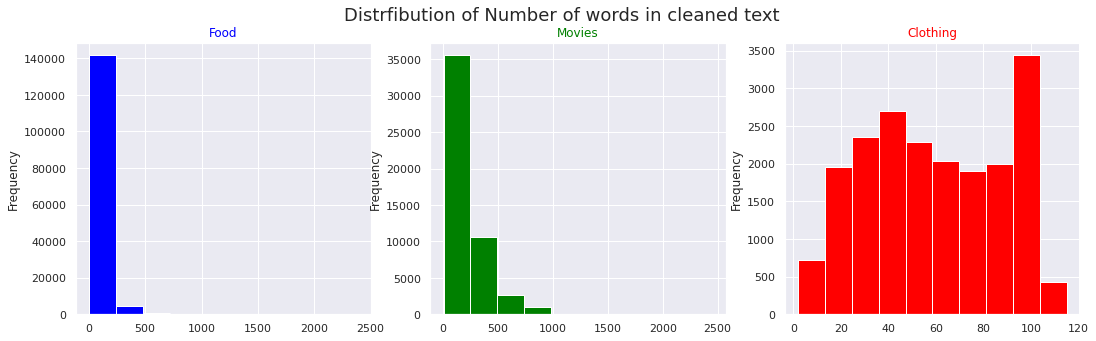

In [136]:
#Distribution of words in the target text
classes = ['Food', 'Movies', 'Clothing']
fig, arr = plt.subplots(1, 3, figsize = (18,5))

color= ['blue', 'green', 'red']

for i in range(3):

    multiclass_lstm[multiclass_lstm['Originally'] == classes[i]]['clean_text'].str.split().str.len().plot.hist(ax = arr[i], color = color[i])
    arr[i].set_title(classes[i], color = color[i]);
    
fig.suptitle('Distrfibution of Number of words in cleaned text', fontsize = 18);

- About 140000 food reviews have about 100 - 200 words
- Abiut 40000 movies reviews have about 100 words

We find the longest sentence to determine our max length 

In [137]:
# Max Length
# calculating length of the longest text to help in sequence padding

multiclass_lstm['review_len'] = multiclass_lstm['clean_text'].apply(len)
print(multiclass_lstm['review_len'].describe())

print('\n\nThe Longest sentence has Maximum length: ', max(multiclass_lstm['review_len']))

#Checkout the mean review length

count    216855.000000
mean        599.043762
std         669.861582
min           9.000000
25%         210.000000
50%         385.000000
75%         714.000000
max       14253.000000
Name: review_len, dtype: float64


The Longest sentence has Maximum length:  14253


In [138]:
multiclass_lstm[multiclass_lstm['clean_text'].isnull()].shape

(0, 5)

In [139]:
multiclass_lstm.sample(5)

,Text,ratings,Originally,clean_text,review_len
48307,This is a mixed revue. We have purchased this same coffee in the past and enjoyed it. This time we are less than enthusiastic. The first bag was so bad I almost called to return the shipment. The second bag is better but not really all that good. My wife is more critical than I am and finds the coffee weak and tasteless. I have tried increasing the amount used with little change in flavor. I have even used bottled spring water with no difference noted.<br /><br />Money wise this is a pretty ...,0,Food,this is a mixed revue we have purchased this same coffee in the past and enjoyed it this time we are le than enthusiastic the first bag wa so bad i almost called to return the shipment the second bag is better but not really all that good my wife is more critical than i am and find the coffee weak and tasteless i have tried increasing the amount used with little change in flavor i have even used bottled spring water with no difference notedmoney wise this is a pretty good bargain but based o...,584
62118,"I have to completely disagree with a previous poster who said that Earth's Best has an unappealing smell and taste compared to Similac Organic. Similac Organic tastes terrible, and smells like spoiled milk when mixed. If you're wanting a quality organic formula, go with Earth's Best. My baby has terrible gas on Similac Organic, and the only reason we buy this, is when we've run out of Earth's Best and have to order more and are in a pinch. Furthermore, Similac Organic doesn't dissolve and le...",0,Food,i have to completely disagree with a previous poster who said that earths best ha an unappealing smell and taste compared to similac organic similac organic taste terrible and smell like spoiled milk when mixed if youre wanting a quality organic formula go with earths best my baby ha terrible gas on similac organic and the only reason we buy this is when weve run out of earths best and have to order more and are in a pinch furthermore similac organic doesnt dissolve and leaf a very nasty res...,619
30673,"Warning: you can't put the bag down... the mix tastes so good that before you know it, you've eaten it all, and one bag is supposedly four servings! But I do recommend it as an excellent trail mix.",3,Food,warning you cant put the bag down the mix taste so good that before you know it youve eaten it all and one bag is supposedly four servings but i do recommend it a an excellent trail mix,185
35568,"This Clear Scalp & Hair Beauty/Therapy conditioner is very good. I have also tried other Clear conditioners and prefer the Total Care and Strong Lengths. They leave my hair both more manageable and shinier than the Ultra Shea does. However, this is a good conditioner, just not my first choice. My hair is fine, thin, dry, and flyaway so if yours is thick, coarse, or oily you may have an entirely different experience.",3,Food,this clear scalp hair beautytherapy conditioner is very good i have also tried other clear conditioner and prefer the total care and strong lengths they leave my hair both more manageable and shinier than the ultra shea does however this is a good conditioner just not my first choice my hair is fine thin dry and flyaway so if yours is thick coarse or oily you may have an entirely different experience,404
173882,"In my opinion, its an outrage that these treats which used to be Made in the US are now Made in China. The company did not advertize anywhere about this and we only found out accidentally while looking at the wrap for ingredients.<br /><br />Let me start my review stating that many of the current 5-star ratings here look suspiciously fake (made up). Its hard to imagine anyone writing something positive about them unless they fail to see reviews clearly warning buyers about these treats being...",0,Food,in my opinion it an outrage that these treat which used to be made in the u are now made in china the company did not advertize anywhere about this and we 

# Splitting dataset into training, validation and testing set

In [ ]:
from sklearn.model_selection import train_test_split
# fix random seed for reproducibility
np.random.seed(7)

#Splitting into training and testing set in the ration 80:20

train_DF, test_DF = train_test_split(multiclass_lstm, test_size = 0.2, random_state = 42)  #We get the testing set


print("Training data size : ", train_DF.shape)
print("Test data size : ", test_DF.shape)

To avoid contamination, we will output the current testing set so it is never touched



In [ ]:
# test_df.to_csv('my_test_file.csv',index=False)
# train_df.to_csv("my_train_set.csv", index = False)